In [132]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from tqdm import tqdm

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# XGBoost import
import xgboost as xgb

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')
print("All libraries imported successfully.")



All libraries imported successfully.


In [133]:
CONFIG = {
        "n_rows": 5000000,       # Reduce row count for a quick run
        "test_size": 0.2,
        "random_state": 42,
        "run_eda": True,         # Set to True to run the EDA
        "results_dir": "results",
        "dnn_epochs": 50,
        "dnn_batch_size": 1024,

    }
os.makedirs(CONFIG["results_dir"], exist_ok=True)
os.makedirs(os.path.join(CONFIG["results_dir"], "eda_plots"), exist_ok=True)

print("Configuration set:")
print(CONFIG)

Configuration set:
{'n_rows': 5000000, 'test_size': 0.2, 'random_state': 42, 'run_eda': True, 'results_dir': 'results', 'dnn_epochs': 50, 'dnn_batch_size': 1024}


In [134]:
COLS = ["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi",
        "lepton 2 pT", "lepton 2 eta", "lepton 2 phi",
        "missing energy magnitude", "missing energy phi", "MET_rel",
        "axial MET", "M_R", "M_TR2", "R", "MT2", "S_R", "M_Delta_R",
        "dPhi_r_b", "cos(theta_r1)"]
LOW_LEVEL_FEATS = COLS[1:9]
HIGH_LEVEL_FEATS = COLS[9:]

In [135]:
def load_and_preprocess_data(config):
    """
    Downloads, loads, preprocesses, splits, and scales the SUSY dataset.
    """
    print("\n--- Starting Data Loading and Preprocessing Step ---")
    try:
        path = kagglehub.dataset_download("janus137/supersymmetry-dataset")
        data_path = os.path.join(path, "supersymmetry_dataset.csv")
        print(f"Dataset found at '{data_path}'.")
    except Exception as e:
        raise FileNotFoundError(f"Could not download data from KaggleHub: {e}")

    print(f"Reading {config['n_rows']} rows...")
    df_full = pd.read_csv(data_path, header=None, names=COLS, nrows=config['n_rows'], skiprows=1)

    X = df_full.drop("signal", axis=1)
    y = df_full["signal"].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=config['test_size'], random_state=config['random_state'], stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

    feature_sets = {
        "all": (X_train_scaled_df, X_test_scaled_df),
        "low_level": (X_train_scaled_df[LOW_LEVEL_FEATS], X_test_scaled_df[LOW_LEVEL_FEATS]),
        "high_level": (X_train_scaled_df[HIGH_LEVEL_FEATS], X_test_scaled_df[HIGH_LEVEL_FEATS])
    }

    print("--- Data Loading and Preprocessing Complete ---\n")
    return X_train_scaled_df, X_test_scaled_df, y_train, y_test, df_full, feature_sets


In [136]:

X_train, X_test, y_train, y_test, df_full, feature_sets = load_and_preprocess_data(CONFIG)



--- Starting Data Loading and Preprocessing Step ---
Dataset found at '/kaggle/input/supersymmetry-dataset/supersymmetry_dataset.csv'.
Reading 5000000 rows...
--- Data Loading and Preprocessing Complete ---



In [137]:
def perform_eda(df, output_dir):
    """
    Performs EDA and saves plots to the output directory.
    """
    print("\n--- Starting Exploratory Data Analysis (EDA) ---")

    sns.displot(data=df_train, x="target", hue="target",legend=True,discrete=True,bins=50)
    plt.xticks([0, 1], label=["Backgroud signal","SUSY signal"])
    plt.title("Target Distribution")
    plt.show()

    # 2. Feature Distribution (Histograms)
    df.drop('signal', axis=1).hist(bins=50, figsize=(22, 16), color='teal')
    plt.suptitle('Histograms of All 18 Features', y=1.0, fontsize=24)
    #plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(os.path.join(output_dir, '2_feature_histograms.pdf'), bbox_inches='tight')
    plt.show()

    # 3. Correlation Matrix
    plt.figure(figsize=(20, 16))
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix Heatmap', fontsize=24)
    plt.savefig(os.path.join(output_dir, '3_correlation_heatmap.pdf'), bbox_inches='tight')
    plt.show()

    print("--- Exploratory Data Analysis Complete ---\n")



In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


def perform_eda(df, target_column):

    print("Distribution of target")
    sns.displot(data=df, x=target_column, hue=target_column, legend=True, discrete=True)
    plt.xticks([0, 1],labels=["Background", "Signal"])
    plt.title("Hedef Değişkenin Dağılımı")
    plt.show()


    print("Correlartion matrix...")
    plt.figure(figsize=(18, 15))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation matrix of all features', fontsize=20)
    plt.show()


    df.drop('signal', axis=1).hist(bins=50, figsize=(22, 16), color='teal')
    plt.suptitle('Histograms of All 18 Features', y=1.0, fontsize=24)
    plt.show()



Distribution of target


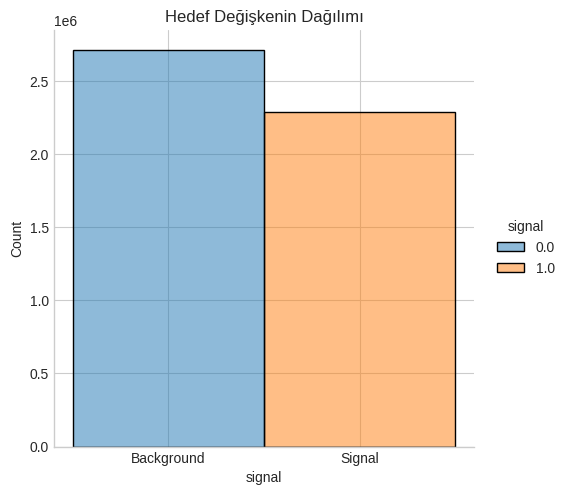

Correlartion matrix...


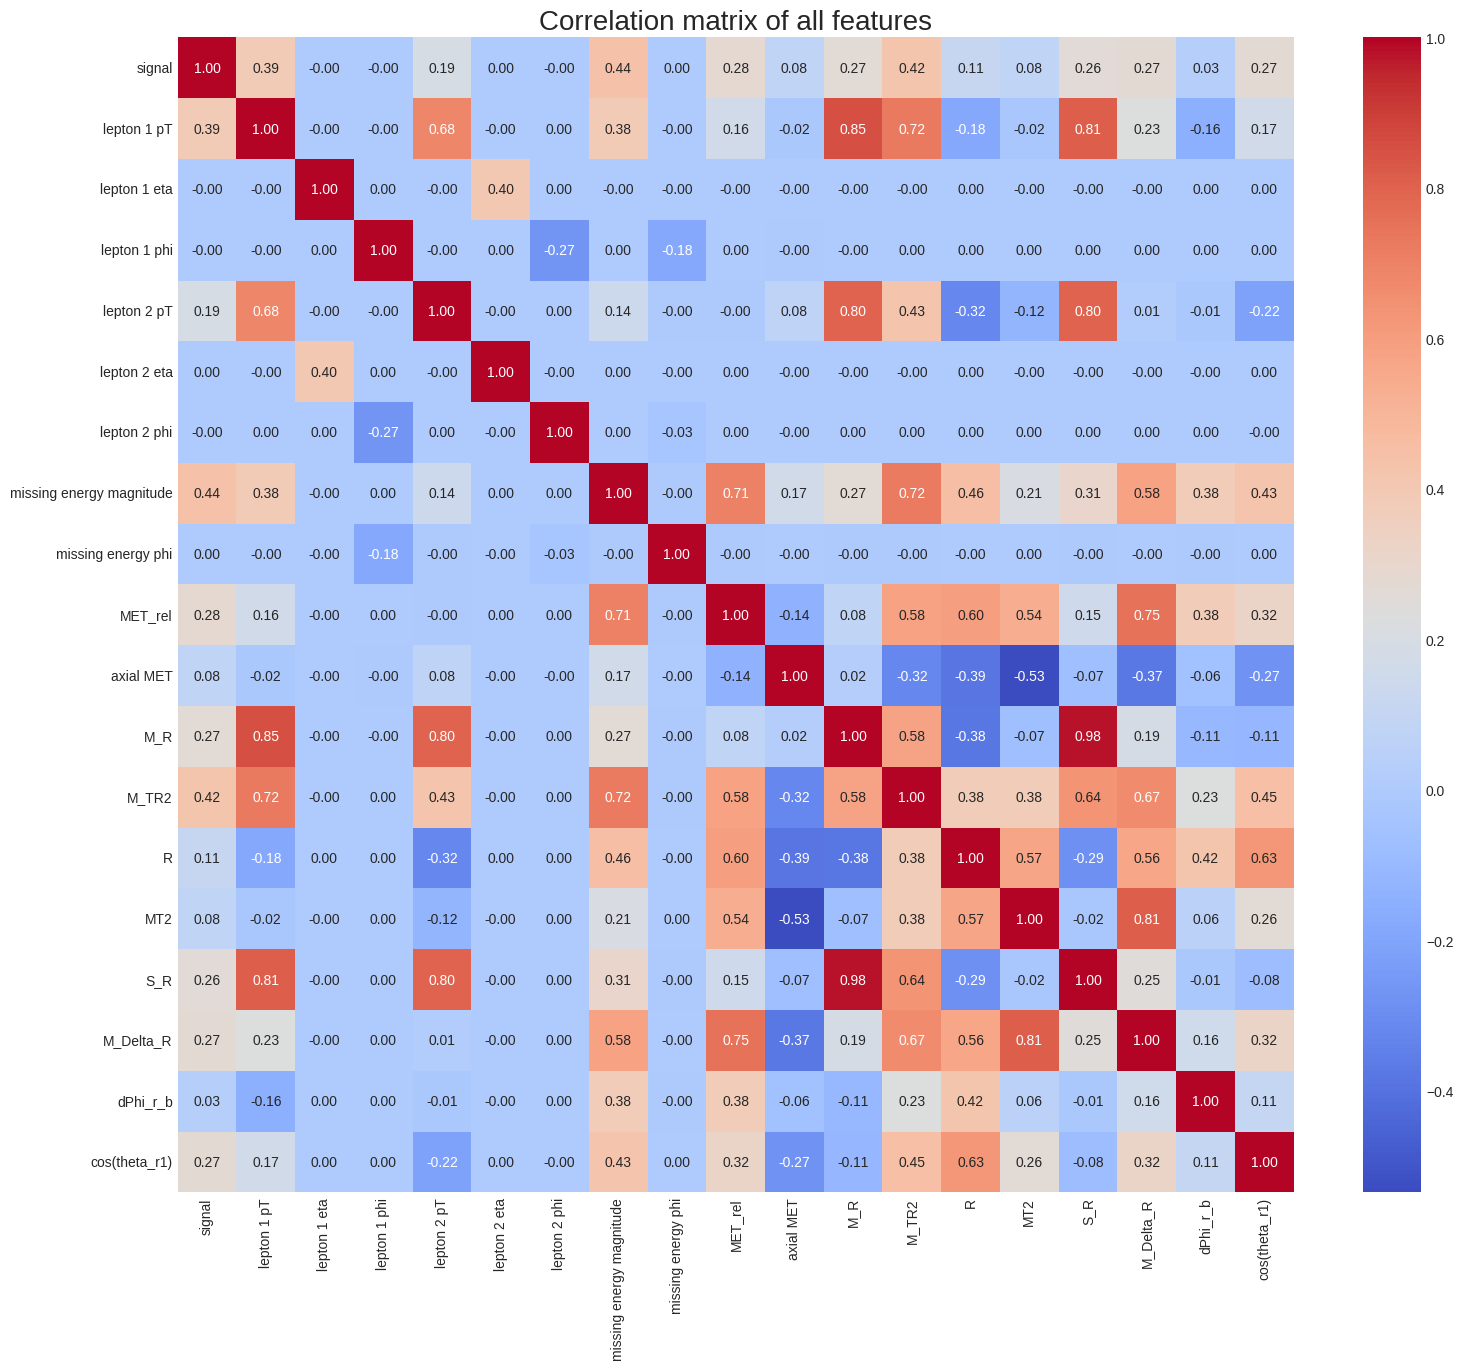

In [ ]:
perform_eda(df=df_full, target_column='signal')



In [ ]:
def train_logistic_regression(X_train, y_train, X_test, y_test):
    print("\n--- Starting Logistic Regression Model Training ---")
    param_grid = [{'penalty': ['l2'], 'C': [0.01, 0.1, 1], 'solver': ['lbfgs'], 'max_iter': [1000]}]
    lr = LogisticRegression(random_state=CONFIG['random_state'])
    grid_search = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Logistic Regression Test AUC: {test_auc:.4f}")
    print("--- Logistic Regression Training Complete ---\n")
    return best_model, test_auc, y_pred_proba


In [ ]:
def train_xgboost(X_train, y_train, X_test, y_test, top_n_features=20):

    print("\n--- Starting XGBoost Model Training with GridSearchCV and Plotting ---")

    param_grid = {
        'n_estimators': [200, 400],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }

    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        # random_state=CONFIG['random_state'], # Eğer CONFIG tanımlı değilse bu satırı yorumlayın
        n_jobs=-1
    )

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        n_jobs=-1
    )
    print("Starting hyperparameter tuning...")
    grid_search.fit(X_train, y_train)

    print("\n--- Hyperparameter Tuning Complete ---")
    print(f"Best Parameters Found: {grid_search.best_params_}")
    print(f"Best CV (Cross-Validation) AUC Score: {grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_

    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nFinal XGBoost Test AUC with Best Model: {test_auc:.4f}")

    print("\n--- Generating Feature Importance Plot ---")

    feature_names = X_train.columns

    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(top_n_features)

    plt.figure(figsize=(10, top_n_features * 0.4))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='dodgerblue')
    plt.xlabel('Özellik Önemi (Importance)')
    plt.ylabel('Özellikler (Features)')
    plt.title(f'En Önemli {top_n_features} Özellik')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("--- XGBoost Training and Plotting Complete ---\n")

    # Bu print satırları fonksiyonun ne döndürdüğünü göstermek için, isteğe bağlıdır.
    print("\n--- Function Return Info ---")
    print(f"Returning Model Type: {type(best_model)}")
    print(f"Returning AUC: {test_auc:.4f}")
    # Düzeltilen Satır: 'predictions.shape' yerine 'y_pred_proba.shape' kullanıldı.
    print(f"Returning Predictions Shape: {y_pred_proba.shape}") # <-- HATA BURADAYDI

    # Fonksiyon doğru değişkenleri döndürüyor.
    return best_model, test_auc, y_pred_proba

In [ ]:
class DNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 300), nn.BatchNorm1d(300), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(300, 300), nn.BatchNorm1d(300), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(300, 300), nn.BatchNorm1d(300), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(300, 1)
        )
    def forward(self, x):
        return self.net(x)


In [ ]:
def train_dnn(X_train, y_train, X_test, y_test, config):
    print("\n--- Starting PyTorch DNN Model Training ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
    y_train_tensor = torch.from_numpy(y_train.values).float().view(-1, 1).to(device)
    X_test_tensor = torch.from_numpy(X_test.values).float().to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=config['dnn_batch_size'], shuffle=True)

    model = DNN(X_train.shape[1]).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(config['dnn_epochs']):
        model.train()
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['dnn_epochs']}", leave=False):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred_proba = torch.sigmoid(model(X_test_tensor)).cpu().numpy().flatten()

    test_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"DNN Test AUC: {test_auc:.4f}")
    print("--- PyTorch DNN Training Complete ---\n")
    return model, test_auc, y_pred_proba



In [ ]:
model_results = {}

# Train Logistic Regression
X_train_all, X_test_all = feature_sets["all"]
lr_model, lr_auc, lr_preds = train_logistic_regression(X_train_all, y_train, X_test_all, y_test)
model_results['Logistic Regression'] = (y_test, lr_preds, lr_auc)

# Train XGBoost
xgb_model, xgb_auc, xgb_preds = train_xgboost(X_train_all, y_train, X_test_all, y_test)
model_results['XGBoost'] = (y_test, xgb_preds, xgb_auc)

# Train DNN
dnn_model, dnn_auc, dnn_preds = train_dnn(X_train_all, y_train, X_test_all, y_test, CONFIG)
model_results['PyTorch DNN'] = (y_test, dnn_preds, dnn_auc)



In [ ]:
print("\n--- Final Performance Summary ---")
for name, (_, _, auc_score) in model_results.items():
    print(f"- {name}: Test AUC = {auc_score:.4f}")

In [ ]:
def plot_model_comparison_roc(results, output_dir):
    """
    Compares the ROC curves of the trained models on a single plot.
    """
    plt.figure(figsize=(12, 10))

    for model_name, (y_true, y_pred_proba, auc_score) in results.items():
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        plt.plot(tpr, 1-fpr, lw=2, label=f'{model_name} (AUC = {auc_score:.4f})') # Note: Plotting TPR vs 1-FPR for physics context

    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance') # Standard ROC
    plt.plot([0, 1], [1, 0], color='grey', lw=2, linestyle='--', label='Random Chance') # For TPR vs 1-FPR
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Signal Efficiency (True Positive Rate)', fontsize=14)
    plt.ylabel('Background Rejection (1 - False Positive Rate)', fontsize=14)
    plt.title('Model Comparison: ROC Curves', fontsize=16)
    plt.legend(loc="lower left", fontsize=12)
    plt.grid(True, alpha=0.5)

    save_path = os.path.join(output_dir, 'model_comparison_roc_curve.pdf')
    plt.savefig(save_path, bbox_inches='tight')
    print(f"\nComparison plot saved to '{save_path}'.")
    plt.show()

In [ ]:
plot_model_comparison_roc(model_results, CONFIG['results_dir'])

print("\n>>> Analysis Pipeline Completed Successfully! <<<")